In [24]:
from scipy import stats as sts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("socialmobility.csv")
data

,father,son,count
0,farm,farm,703
1,farm,unskilled,1478
2,farm,skilled,1430
3,farm,professional,1109
4,unskilled,farm,58
5,unskilled,unskilled,1756
6,unskilled,skilled,1630
7,unskilled,professional,1568
8,skilled,farm,63
9,skilled,unskilled,1453


In [48]:
subset = data[data.father == "unskilled"]
"""
Setting a uniform distribution over 
the probability vector parameter of the multinomial.
"""
alpha_priors = np.repeat(1, len(subset))
"""
based on the conjugate prior table, we can compute the posterior 
hyperparameters of the Dirichlet posterior distribution by
"""
alpha_posteriors = [alpha_priors[i] + subset['count'].iloc[i] for i in range(len(subset))]

posterior = sts.dirichlet(alpha_posteriors)

samples = posterior.rvs(size=10**5)

"""
What is the posterior 95% probability interval over the probability that a son will
become a skilled laborer if his father was an unskilled laborer?
"""
print("95% CI that the son is skilled while father is unskilled\n",
      np.percentile(samples[:,2], [2.5, 97.5]))


"""
What is the posterior 95% probability interval over the probability that a son will
become a professional laborer if his father was an unskilled laborer?
"""
print("\n95% CI that the son is professional while father is unskilled\n",
      np.percentile(samples[:,3], [2.5, 97.5]))

95% CI that the son is skilled while father is unskilled
 [0.31220254 0.33826378]

95% CI that the son is professional while father is unskilled
 [0.30010122 0.32565323]


In [53]:
"""
What is the posterior 95% probability interval over the probability that a father 
works on a farm if his son works as a professional?
"""

subset2 = data[data.son == "professional"]
print(subset2)
alpha_priors = np.repeat(1, len(subset2))

alpha_posteriors = [alpha_priors[i] + subset2['count'].iloc[i] for i in range(len(subset2))]

posterior2 = sts.dirichlet(alpha_posteriors)
samples2 = posterior2.rvs(size=10**5)

print("\n95% CI that father works in a farm if son is a professional\n",
      np.percentile(samples2[:,0], [2.5, 97.5]))

          father           son  count
3           farm  professional   1109
7      unskilled  professional   1568
11       skilled  professional   2483
15  professional  professional   3315

95% CI that father works in a farm if son is a professional
 [0.12379266 0.13817723]


In [62]:
mult = sts.multinomial(100, [1/6, 1/6, 1/6, 1/6, 1/6, 1/6])
num_samples = 2
print('Generating', num_samples, 'samples:')
samples = mult.rvs(size=num_samples)


print(samples)
print('Value of probability mass function at samples:')
print(mult.pmf(samples))

Generating 2 samples:
[[19 15 18 18 15 15]
 [16 16 15 18 16 19]]
Value of probability mass function at samples:
[1.28115926e-05 1.53138568e-05]


In [57]:
dirichlet = sts.dirichlet([1, 2, 3, 4])
num_samples = 5
print('Generating', num_samples, 'samples:')
samples = dirichlet.rvs(size=num_samples)
print(samples)
print('Sum of each sample (should be 1):')
print(samples.sum(axis=1))
print('Value of probability density function at each sample:')
print(dirichlet.pdf(samples.transpose()))

Generating 5 samples:
[[0.16894931 0.40277231 0.20100879 0.22726959]
 [0.07946066 0.11558479 0.27263706 0.53231749]
 [0.14153622 0.15326053 0.59219034 0.11301291]
 [0.22383789 0.08118641 0.33564232 0.35933338]
 [0.00160571 0.41745923 0.39209485 0.18884022]]
Sum of each sample (should be 1):
[1. 1. 1. 1. 1.]
Value of probability density function at each sample:
[ 5.77690819 39.18902484  2.34595107 12.83249877 13.06957865]


## Using the Stan simulation [example from class]

In [66]:
import pystan
# Code the type of work with integers
farm = 0
unskilled = 1
skilled = 2
professional = 3

# Matrix of counts such that, for example, counts[farm][skilled] is the
# number of times a father does farm work and a son skilled work.
counts = [
    [703, 1478, 1430, 1109],
    [58, 1756, 1630, 1568],
    [63, 1453, 2068, 2483],
    [61, 749, 1183, 3315]]

In [64]:
# This is a partial Stan model. Look up how to define the multinomial
# and dirichlet distributions in your likelihood and prior.

stan_code = """

data {
    int<lower=1> C;    // number of categories in the multinomial
    vector[C] alpha;   // prior hyperparameters for Dirichlet
    int counts[C];     // the data set: counts for each category
}

parameters {
    simplex[C] theta;  // the probability vector over categories
}

model {

    theta ~ dirichlet(alpha); // prior
    counts ~ multinomial(theta); // likelihood
}
"""

stan_model = pystan.StanModel(model_code=stan_code)  

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4288838636dda9ea0168308ec88e8b29 NOW.


In [67]:
# Generate results

# NOTE: The easiest option is to generate one set of posterior samples
# for each row in the counts matrix.

stan_data = {
    'C': 4,
    'alpha': [1, 1, 1, 1],
    'counts': counts[unskilled],
}

results = stan_model.sampling(data=stan_data)

In [68]:
results

Inference for Stan model: anon_model_4288838636dda9ea0168308ec88e8b29.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   0.01  2.3e-5 1.5e-3 9.0e-3   0.01   0.01   0.01   0.01   4198    1.0
theta[2]   0.35  1.1e-4 6.8e-3   0.34   0.35   0.35   0.35   0.36   3656    1.0
theta[3]   0.33  1.1e-4 6.6e-3   0.31   0.32   0.33   0.33   0.34   3786    1.0
theta[4]   0.31  1.0e-4 6.6e-3    0.3   0.31   0.31   0.32   0.33   4006    1.0
lp__      -5762    0.03   1.23  -5765  -5763  -5762  -5761  -5761   2086    1.0

Samples were drawn using NUTS at Thu Oct 17 12:47:43 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [74]:
print(results.stansummary(pars=['theta'], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_4288838636dda9ea0168308ec88e8b29.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
theta[1]   0.01  2.3e-5 1.5e-3 9.0e-3   0.01   0.01   4198    1.0
theta[2]   0.35  1.1e-4 6.8e-3   0.34   0.35   0.36   3656    1.0
theta[3]   0.33  1.1e-4 6.6e-3   0.31   0.33   0.34   3786    1.0
theta[4]   0.31  1.0e-4 6.6e-3    0.3   0.31   0.33   4006    1.0

Samples were drawn using NUTS at Thu Oct 17 12:47:43 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


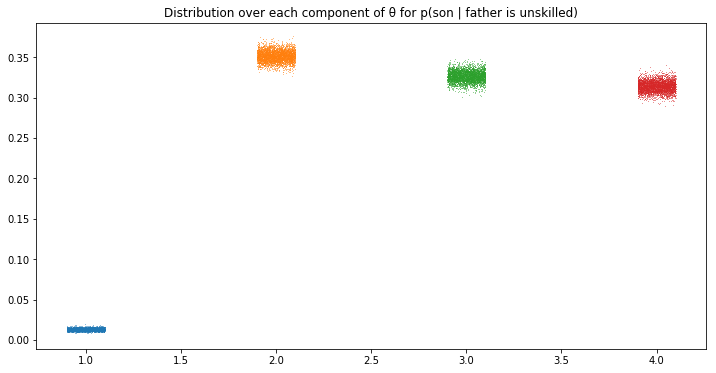

In [77]:
samples = results.extract()
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(sts.uniform.rvs(loc=i+1-0.1, scale=0.2, size=samples['theta'].shape[0]), 
             samples['theta'][:,i], ',', alpha=0.5)
plt.title('Distribution over each component of θ for p(son | father is unskilled)')
plt.show()